In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report 

In [2]:
# set plot options
plt.rcParams['figure.figsize'] = (12,8)
default_plot_colour = "#00bfbf"

In [3]:
data = pd.read_csv("fake_news_data.csv") 

In [4]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

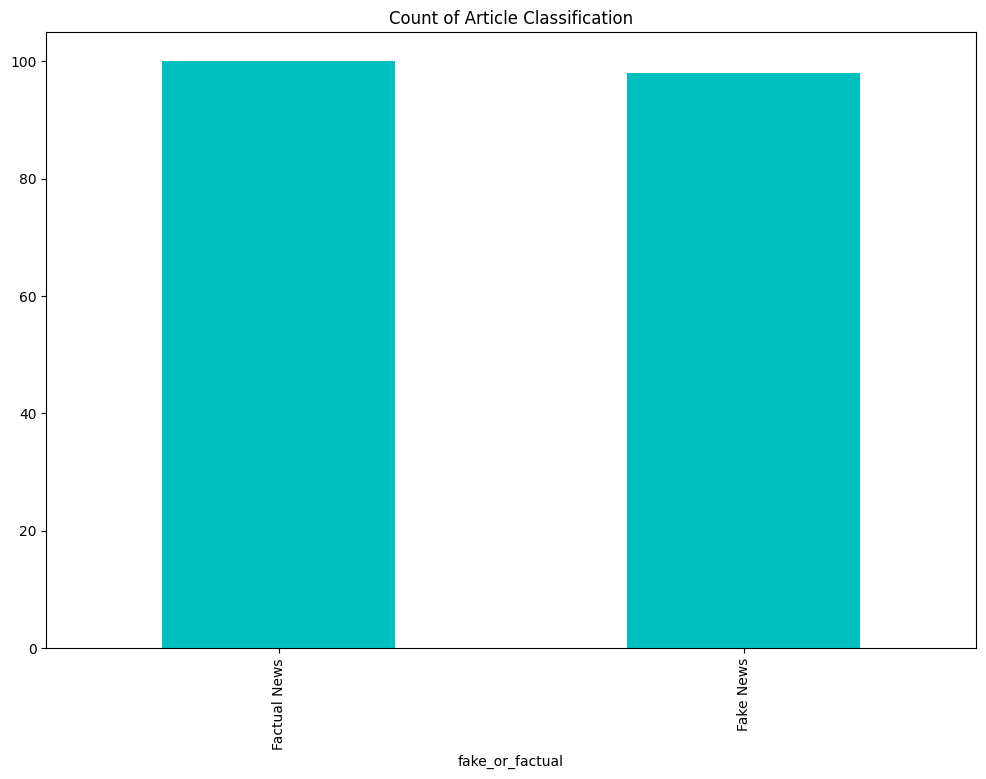

In [6]:
data['fake_or_factual'].value_counts().plot(kind="bar", color=default_plot_colour)
plt.title("Count of Article Classification")

# POS Tagging

In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [9]:
fake_news.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News


In [10]:
fact_news.head()

,title,text,date,fake_or_factual
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News
11,Kerry says can't comment on content of Clinton...,QUEBEC CITY (Reuters) - U.S. Secretary of Stat...,"January 29, 2016",Factual News


In [11]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [12]:
fake_spacydocs

[There are two small problems with your analogy Susan  Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim  refugees  to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis   a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly,  Sarandon wrote of her experience.  She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having give

In [13]:
fact_spacydocs

[WASHINGTON (Reuters) - U.S. Defense Secretary Jim Mattis said on Monday that Russia s bombing of U.S-backed fighters in Syria was being discussed at the highest levels and while a communication link between the two countries had worked to avoid such incidents, the strike over the weekend was a departure.  When you look at the fact that this is a change, you can imagine this is at the highest levels,  Mattis told reporters. Russia s Defense Ministry on Sunday rejected the allegations, saying its planes only targeted Islamic State militants and that it had warned the United States well in advance of its operational plans. ,
 BELFAST (Reuters) - Northern Ireland s political parties are rapidly running out of time to restore a devolved power-sharing government, Britain s minister for the region said on Monday, as he sought to avoid a return of direct rule from London.  The window of opportunity to restore devolution and to form an executive is closing rapidly as we move further into the a

In [14]:
def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [15]:
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

In [16]:
for ix,doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [17]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [18]:
fake_tagsdf.head(20)

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN
5,with,,ADP
6,your,,PRON
7,analogy,,NOUN
8,Susan,PERSON,PROPN
9,,PERSON,SPACE


In [19]:
fact_tagsdf = []

for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

In [20]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [21]:
fact_tagsdf.head(20)

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT
5,U.S.,GPE,PROPN
6,Defense,,PROPN
7,Secretary,,PROPN
8,Jim,PERSON,PROPN
9,Mattis,PERSON,PROPN


In [22]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [23]:
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [24]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [25]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [26]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][0:10]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [27]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][0:10]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


## Named Entities

In [28]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)

In [29]:
top_entities_fake.groupby('ner_tag')['token'].count().sort_values(ascending=False).head(10)

ner_tag
ORG         639
PERSON      617
DATE        238
GPE         184
CARDINAL    121
NORP         71
MONEY        59
TIME         44
FAC          36
PERCENT      31
Name: token, dtype: int64

In [30]:
top_entities_fake.head()

,token,ner_tag,counts
1730,Trump,PERSON,154
1729,Trump,ORG,152
2129,the,ORG,121
592,Clinton,PERSON,118
718,Donald,PERSON,75


In [31]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)

In [32]:
top_entities_fact.groupby('ner_tag')['token'].count().sort_values(ascending=False).head(10)

ner_tag
PERSON      545
ORG         524
GPE         232
DATE        220
CARDINAL    106
NORP         85
MONEY        47
LOC          45
PERCENT      39
QUANTITY     38
Name: token, dtype: int64

In [33]:
top_entities_fact.head()

,token,ner_tag,counts
1968,the,ORG,159
1633,U.S.,GPE,138
1373,Reuters,ORG,131
1615,Trump,PERSON,125
1614,Trump,ORG,124


In [34]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Named Entites in Fake News')]

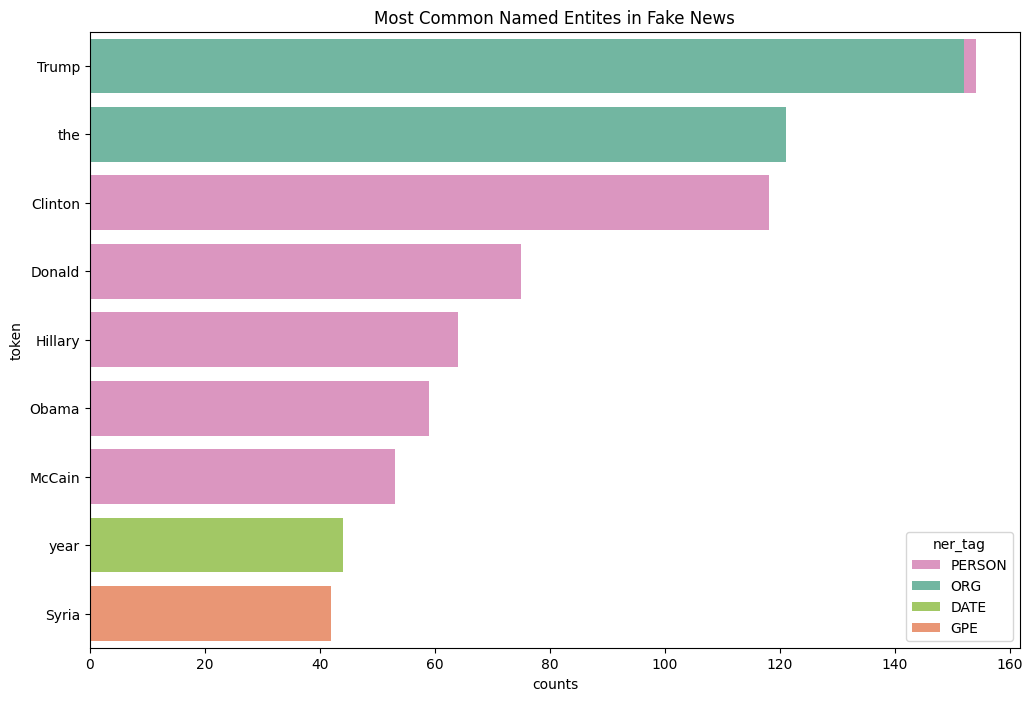

In [35]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[:10],
    orient = 'h',
    dodge = False
).set(title="Most Common Named Entites in Fake News")

[Text(0.5, 1.0, 'Most Common Named Entites in Factual News')]

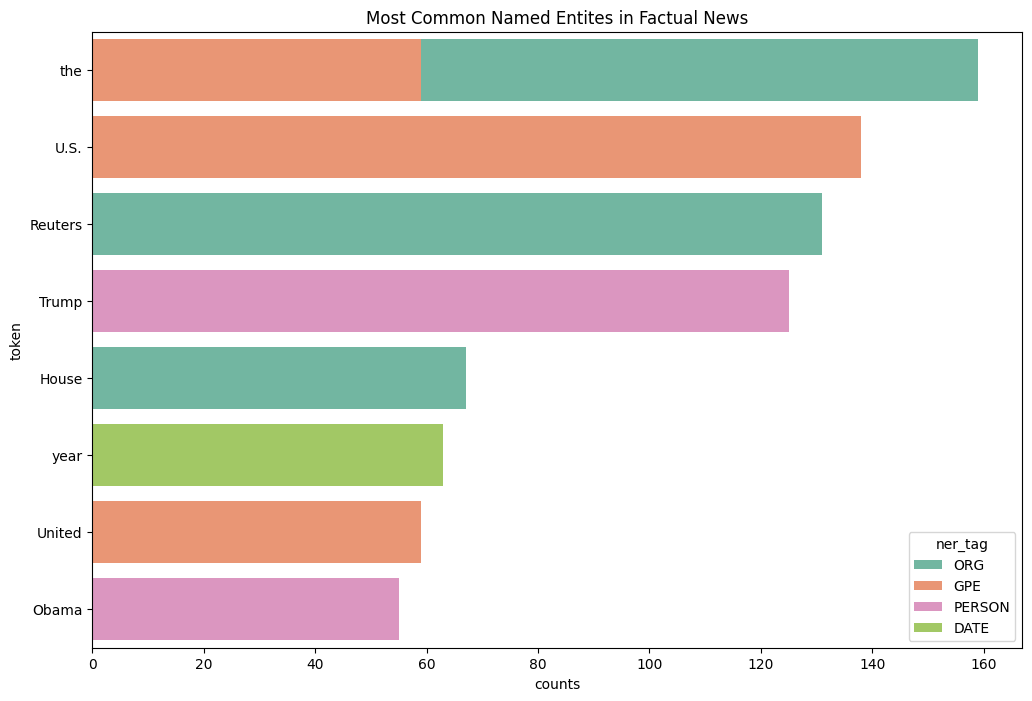

In [36]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[:10],
    orient = 'h',
    dodge = False
).set(title="Most Common Named Entites in Factual News")

## Text Pre-Processing

In [37]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [38]:
data["text_clean"] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x["text"]), axis=1)

In [39]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


In [40]:
data["text_clean"] = data["text_clean"].str.lower()

In [41]:
data["text_clean"] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x["text_clean"]), axis=1)

In [42]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said on monday...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


In [43]:
en_stopwords = stopwords.words("english")
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [44]:
data["text_clean"] = data["text_clean"].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [45]:
data["text_clean"] = data.apply(lambda x: word_tokenize(x["text_clean"]), axis=1)

In [46]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [47]:
data["text_clean"] = data["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [48]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [49]:
tokens_clean = sum(data["text_clean"], [])

In [50]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


C:\Users\Asus\AppData\Local\Temp\ipykernel_26536\11718096.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x="count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

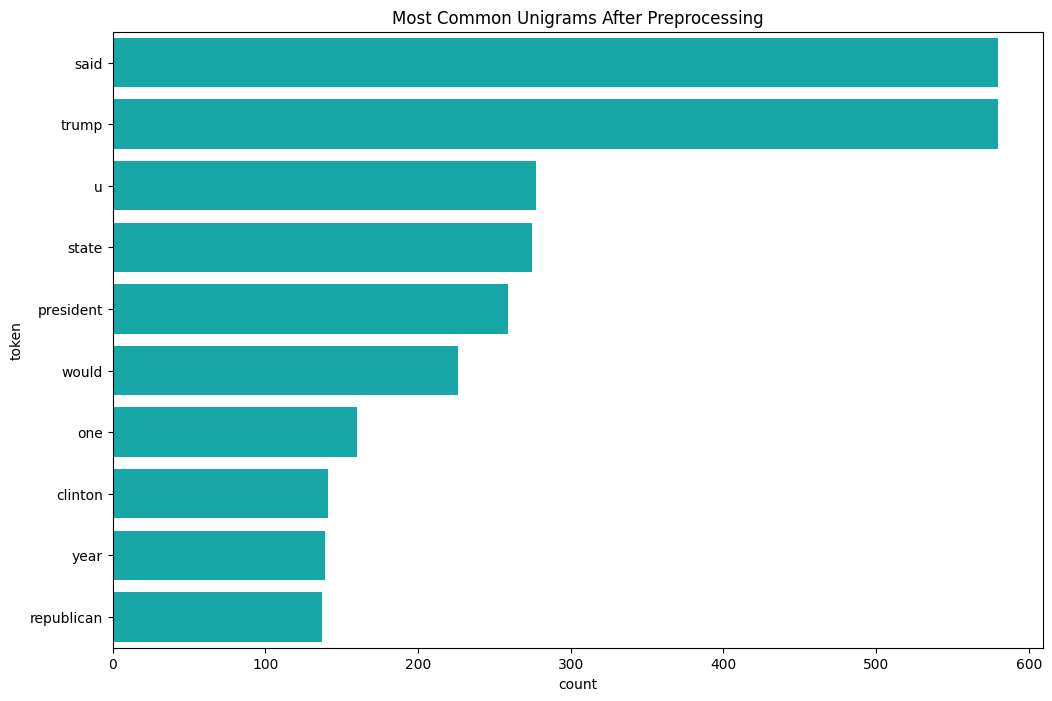

In [51]:
unigrams["token"] = unigrams["index"].apply(lambda x: x[0])

sns.barplot(x="count",
            y="token",
            data = unigrams,
            orient = "h",
            palette = [default_plot_colour],
            hue = "token", legend=False
           ).set(title = "Most Common Unigrams After Preprocessing")

In [52]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


# Sentiment Analysis

In [53]:
vader_sentiment = SentimentIntensityAnalyzer()

In [54]:
data["vader_sentiment_score"] = data["text"].apply(lambda x: vader_sentiment.polarity_scores(x)["compound"])

In [55]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [56]:
bins = [-1, -0.1, 0.1, 1]
names = ["negative", "neutral", "positive"]

In [57]:
data["vader_sentiment_label"] = pd.cut(data["vader_sentiment_score"], bins , labels = names)

In [58]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

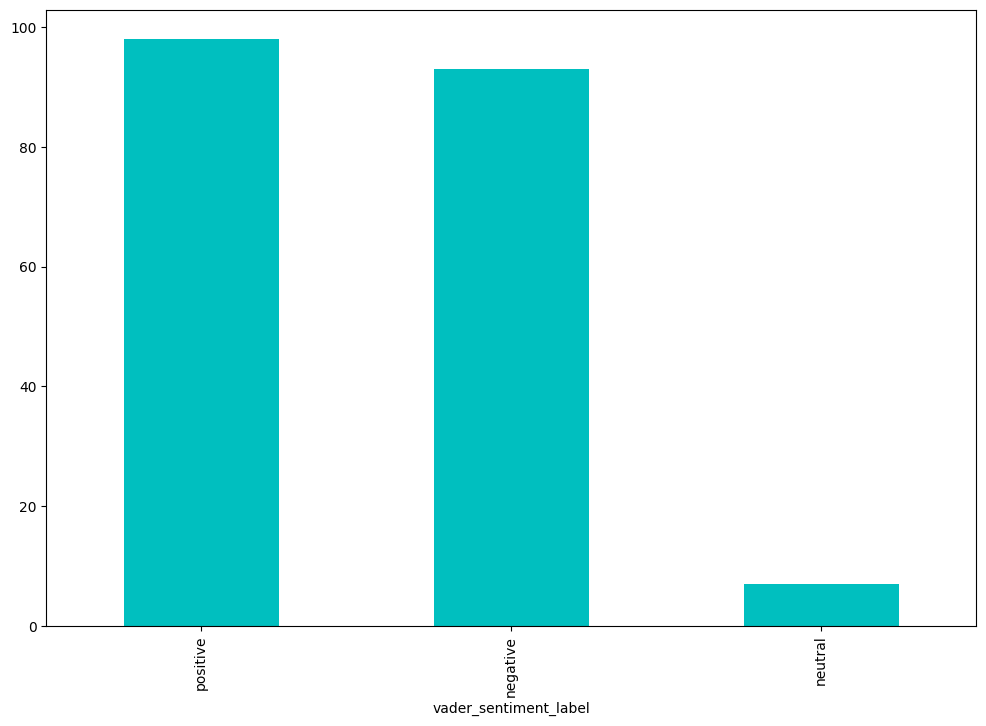

In [59]:
data["vader_sentiment_label"].value_counts().plot.bar(color=default_plot_colour)

C:\Users\Asus\AppData\Local\Temp\ipykernel_26536\1004999411.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

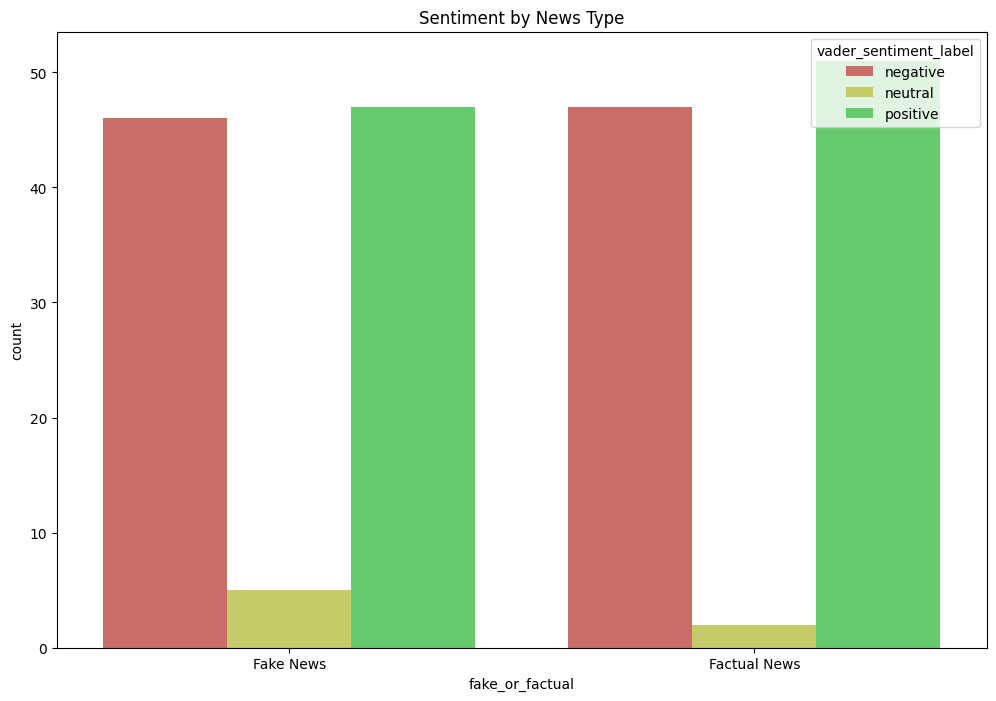

In [60]:
sns.countplot(
    x = "fake_or_factual",
    hue = "vader_sentiment_label",
    palette = sns.color_palette("hls"),
    data = data
).set(title = "Sentiment by News Type")

# Topic Modelling

In [61]:
fake_news_text = data[data["fake_or_factual"] == "Fake News"]["text_clean"].reset_index(drop=True)

In [62]:
fake_news_text[:10]

0    [two, small, problem, analogy, susan, jesus, m...
1    [buried, trump, bonkers, interview, new, york,...
2    [woman, make, 50, percent, country, grossly, u...
3    [shame, teen, vogue, maxine, water, guest, tee...
4    [former, white, house, press, secretary, obama...
5    [donald, trump, intensely, bizarre, crazy, twe...
6    [shrill, old, socialist, carla, marx, wannabe,...
7    [obama, year, record, food, stamp, usage, pres...
8    [hillary, clinton, say, stronger, together, ev...
9    [tune, alternate, current, radio, network, acr...
Name: text_clean, dtype: object

In [63]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [64]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [65]:
print(doc_term_fake)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 4), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 2), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 3), (59, 3), (60, 1), (61, 3), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 3), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 6), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 2), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 2)

In [66]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics = num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence="c_v")
    coherence_values.append(coherence_model.get_coherence())

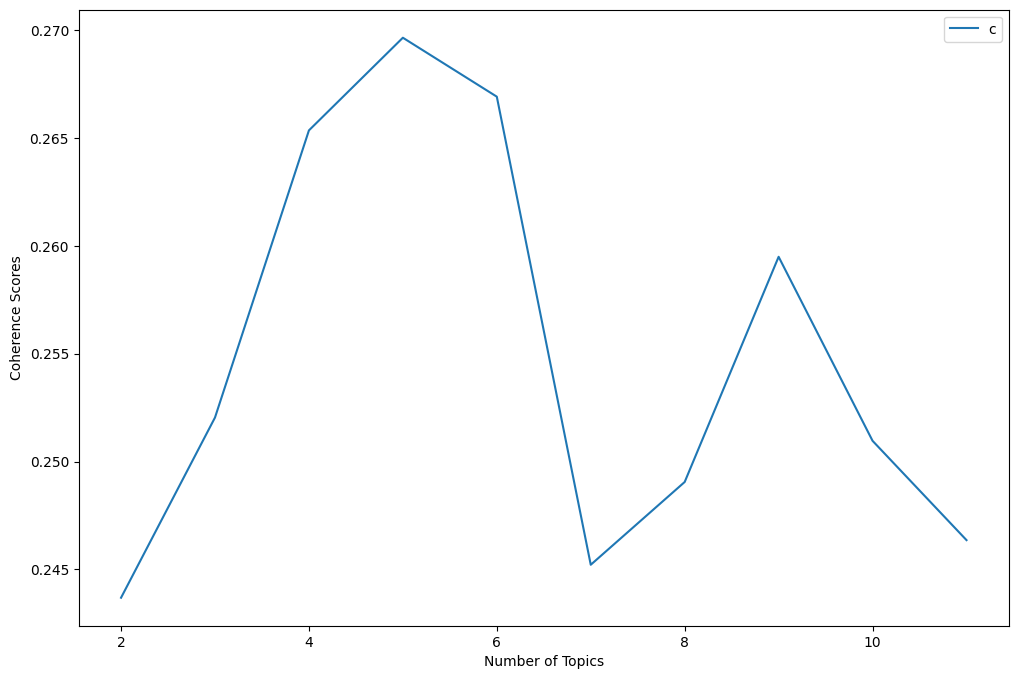

In [67]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [68]:
num_topics_lda = 3
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_lda)

In [69]:
lda_model.print_topics(num_topics = num_topics_lda, num_words=10)

[(0,
  '0.012*"trump" + 0.005*"said" + 0.005*"state" + 0.004*"president" + 0.004*"u" + 0.004*"time" + 0.004*"one" + 0.003*"clinton" + 0.003*"would" + 0.003*"republican"'),
 (1,
  '0.010*"trump" + 0.004*"clinton" + 0.004*"said" + 0.004*"state" + 0.003*"would" + 0.003*"time" + 0.003*"u" + 0.003*"president" + 0.003*"mccain" + 0.003*"donald"'),
 (2,
  '0.011*"trump" + 0.005*"president" + 0.004*"said" + 0.004*"clinton" + 0.004*"one" + 0.004*"would" + 0.004*"woman" + 0.003*"state" + 0.003*"u" + 0.003*"republican"')]

In [70]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus = doc_term_matrix, normalize = True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [71]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics= num_topics_i , id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts= text, dictionary=dictionary, coherence = "c_v")
        coherence_values.append(coherence_model.get_coherence())
        
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.legend(("coherence_values"), loc="best")
    plt.show()

In [72]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

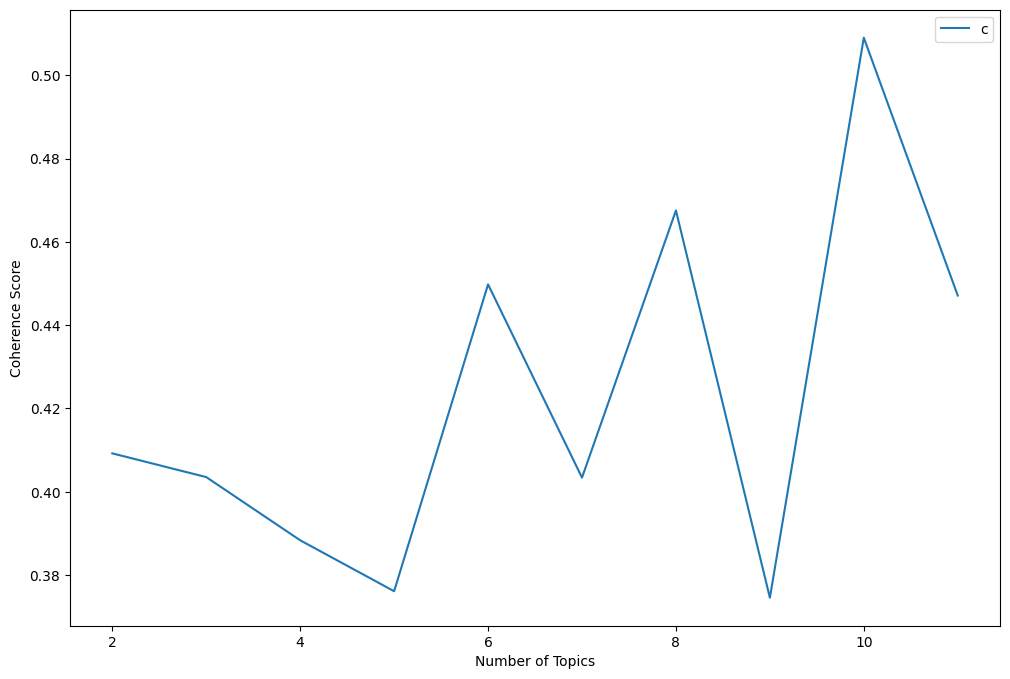

In [73]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [74]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics= 8)

In [75]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '0.325*"boiler" + 0.284*"acr" + 0.244*"room" + 0.240*"pm" + 0.186*"broadcast" + 0.180*"radio" + 0.142*"animal" + 0.142*"tune" + 0.134*"jay" + 0.132*"episode"'),
 (2,
  '0.623*"flynn" + 0.182*"immunity" + 0.122*"nana" + 0.116*"mr" + 0.110*"30" + 0.108*"march" + 0.102*"russian" + 0.100*"source" + -0.095*"school" + 0.092*"adviser"'),
 (3,
  '-0.217*"clinton" + 0.186*"school" + 0.176*"student" + -0.141*"hillary" + 0.121*"county" + 0.121*"flynn" + -0.110*"sander" + -0.098*"debate" + -0.097*"woman" + -0.091*"nominee"'),
 (4,
  '-0.200*"email" + 0.194*"trump" + -0.168*"dnc" + 0.142*"flynn" + -0.126*"clinton" + 0.112*"cruz" + -0.111*"department" + -0.110*"rich" + -0.102*"wikileaks" + -0.099*"sander"'),
 (5,
  '0.276*"student" + 0.160*"conference" + 0.160*"school" + 0.137*"trump" + -0.125*"mccain" + -0.12

Creating our 